In [1]:
import numpy as np
from matplotlib import pyplot as plt
import DSPPythonWrapper as wrp
import ipywidgets as widgets

## Global parameters/constants
plt.rcParams['figure.figsize'] = [8, 8]

In [2]:
mesh_width = 89.21  # mm
mesh_height = 71.35  # mm
spatial_resolution = 5  # mm

mesh = wrp.Triangular2DMesh(mesh_width, mesh_height,
    spatial_resolution)

mesh_coords = mesh.GetMeshCoordinates()
# How large should this vector be?
lenk_internal = np.ceil(mesh_width * 2 / spatial_resolution)
lenk_internal += 1 - np.mod(lenk_internal, 2)
expected_c = np.ceil(mesh_height / (spatial_resolution
    * np.sqrt(3) / 2))
expected_c += np.mod(expected_c, 2)
expected_k_odd = lenk_internal // 2
expected_k_even = lenk_internal // 2 + 1
expected_data_length = expected_c * expected_k_even - (expected_c // 2)
assert(expected_data_length == mesh_coords.shape[0])
assert(2 == mesh_coords.shape[1])
assert(mesh_coords.dtype == np.float32)
print("All assertions passed")

All assertions passed


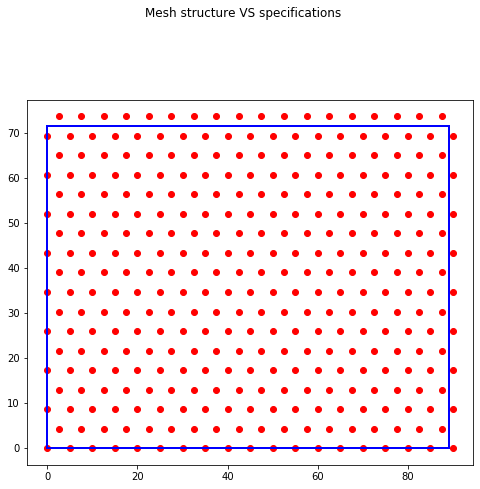

In [3]:
## Plot mesh coordinates

def plot_mesh(title):
    fig = plt.figure()
    ax = plt.axes()
    plt.scatter(mesh_coords[:,0], mesh_coords[:,1], c="r")
    ax.set_aspect("equal")
    fig.suptitle(title)
    return (fig, ax)

fig, ax = plot_mesh("Mesh structure VS specifications")
from matplotlib.patches import Rectangle
mesharea = Rectangle((0, 0), mesh_width, mesh_height, facecolor='none', linewidth=2, edgecolor="b")
_ = ax.add_patch(mesharea)

In [4]:
## Inspect mesh mask

mesh_mask = mesh.GetMask()
assert(expected_data_length == mesh_mask.shape[0])
assert(6 == mesh_mask.shape[1])
print("All assertions passed")

All assertions passed


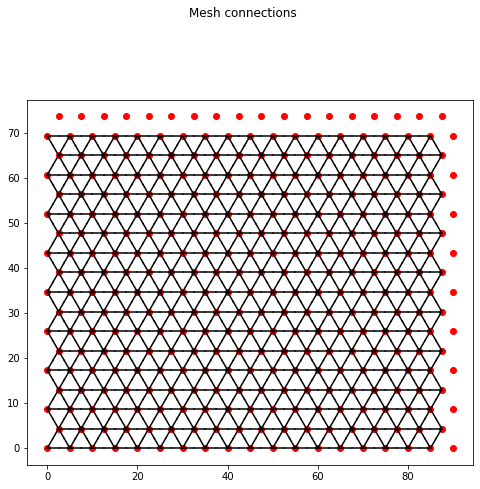

In [5]:
## Plot mesh mask structure

def getLinePoints(xp, yp, direction):
    """
    xp, yp: coordinates of the mesh point
    direction: enum of the direction clockwise (NE, E, SE, SW, W, NW)
    """
    angles = np.arange(-np.pi/3, 5/3*np.pi, np.pi/3)
    yd = np.sin(angles[direction]) * spatial_resolution / 2 + yp
    xd = np.cos(angles[direction]) * spatial_resolution / 2 + xp
    return ((xd, xp), (yd, yp))

fig, ax = plot_mesh("Mesh connections")
for point_idx, point_coords in enumerate(mesh_coords):
    point_mask = mesh_mask[point_idx]
    for dir, dirmask in enumerate(point_mask):
        if point_mask[dir]:
            plt.plot(*getLinePoints(*point_coords, dir), color="k")

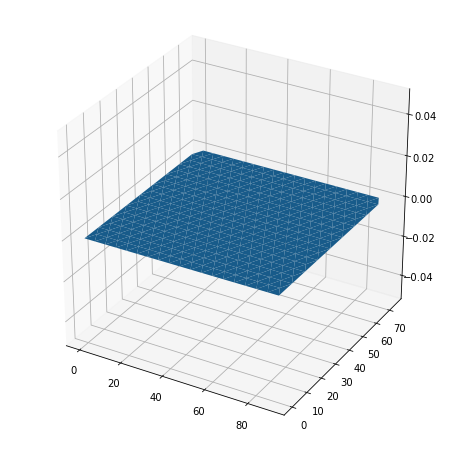

In [6]:
## Verify zeroing-out of initial junction pressure

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
_ = ax.plot_trisurf(mesh_coords[:,0], mesh_coords[:,1], mesh.GetV())

Widget Javascript not detected.  It may not be installed or enabled properly.


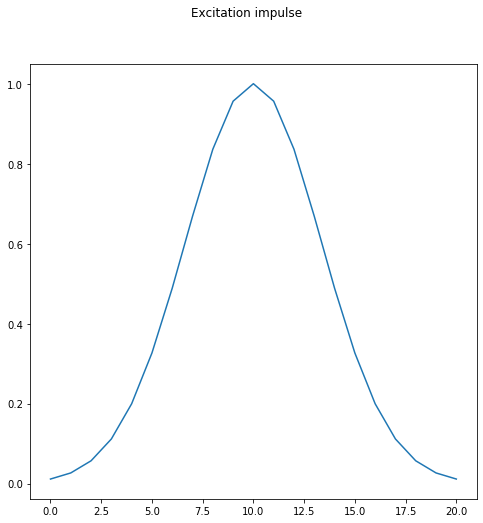

In [7]:
## Generate Gaussian impulse as stimulus
from scipy.signal import gaussian
M = 21
impulse = gaussian(M, M/2/np.pi)
fig = plt.figure()
fig.suptitle("Excitation impulse")
ax = fig.gca()
fig_ = ax.plot(impulse)
# Serialise C-style into textbox for export
impulse_data_str = ["\n    " + str(n) if i % 4 == 0 else str(n) for i,n in enumerate(impulse)]
impulse_str = "float impulse[%s] = \n{%s\n};" % (
    len(impulse),
    ",".join(impulse_data_str)
)
widgets.Text(value=impulse_str) 

In [8]:
fig = plt.figure("Pickup signal")
ax = plt.gca()
fig3d = plt.figure("Mesh velocity")
ax3d = fig.gca(projection='3d')
pickup_output = np.zeros(len(impulse))

for smpidx, imp_sample in enumerate(impulse):
    pickup_output[smpidx] = mesh.ProcessSample(True, imp_sample)
    ax.plot(pickup_output)
    fig.show()